<a href="https://colab.research.google.com/github/Gopib03/Pytorch_Models/blob/main/Using_PyTorch_to_fine_tune_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
torch.use_deterministic_algorithms(True)


In [4]:
# Download and extract the dataset if it doesn't exist
ddir = 'hymenoptera_data'
if not os.path.exists(ddir):
    !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
    !unzip hymenoptera_data.zip

# Data normalization and augmentation transformations
# for train dataset
# Only normalization transformation for validation dataset
# The mean and std for normalization are calculated as the
# mean of all pixel values for all images in the training
# set per each image channel - R, G and B
data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                     [0.490, 0.449, 0.411],
                                     [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   [0.490, 0.449, 0.411],
                                   [0.231, 0.221, 0.230])])}
img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k])
            for k in ['train', 'val']}
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8,
                                           shuffle=True)
            for k in ['train', 'val']}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

--2026-01-02 18:27:43--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.100.77, 54.192.100.22, 54.192.100.11, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.100.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  67.9MB/s    in 0.7s    

2026-01-02 18:27:44 (67.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat

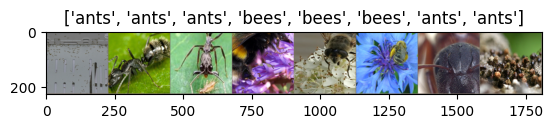

In [5]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)
# Generate one train dataset batch
imgs, cls = next(iter(dloaders['train']))
# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)
imageshow(grid, text=[classes[c] for c in cls])


In [16]:
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    accuracy = 0.0
    model_weights = copy.deepcopy(pretrained_model.state_dict())

    for e in range(epochs):
        for dset in ['train', 'val']:
            loss = 0.0
            successes = 0
            if dset == 'train':
                # set model to train mode
                # (i.e. trainbale weights)
                pretrained_model.train()
            else:
                # set model to validation mode
                pretrained_model.eval()
            # iterate over the (training/validation) data.
            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()
                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    # backward pass only if in training mode
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()
                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)
            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]
            print(f'{dset} Loss: {loss_epoch:.4f} Acc: {accuracy_epoch:.4f}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(
                    pretrained_model.state_dict())
    # load the best model version (weights)
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model

In [10]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'Prediction:\n{classes[preds[j]]},\nGround Truth:\n{classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])
                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [11]:
model_finetune = models.alexnet(pretrained=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 94.5MB/s]


In [12]:
print(model_finetune.features)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [13]:
print(model_finetune.classifier)


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [14]:
# change the last layer from 1000 classes to 2 classes
model_finetune.classifier[6] = nn.Linear(4096, len(classes))


In [17]:
loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetune.parameters(), lr=0.0001)
# train (fine-tune) and validate the model
model_finetune = finetune_model(model_finetune, loss_func,
                                optim_finetune, epochs=10)


train Loss: 0.7140 Acc: 0.5656
val Loss: 0.5794 Acc: 0.6993
train Loss: 0.5567 Acc: 0.7582
val Loss: 0.4917 Acc: 0.7582
train Loss: 0.4823 Acc: 0.7828
val Loss: 0.4386 Acc: 0.7843
train Loss: 0.4400 Acc: 0.8074
val Loss: 0.4027 Acc: 0.8431
train Loss: 0.4074 Acc: 0.8197
val Loss: 0.3744 Acc: 0.8562
train Loss: 0.4170 Acc: 0.8402
val Loss: 0.3595 Acc: 0.8627
train Loss: 0.4082 Acc: 0.8197
val Loss: 0.3468 Acc: 0.8693
train Loss: 0.3380 Acc: 0.8770
val Loss: 0.3346 Acc: 0.8693
train Loss: 0.3677 Acc: 0.8361
val Loss: 0.3271 Acc: 0.8693
train Loss: 0.3330 Acc: 0.8566
val Loss: 0.3157 Acc: 0.8824


Best validation set accuracy is 88.24


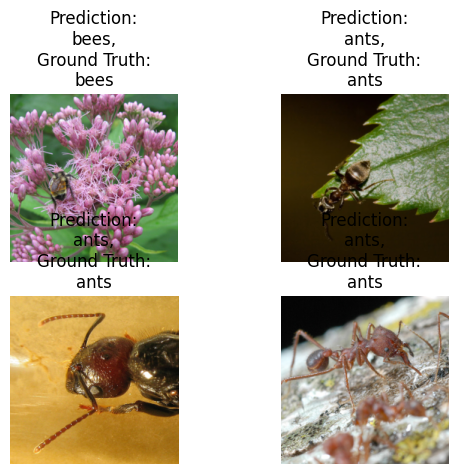

In [18]:
visualize_predictions(model_finetune)
